# compute AVO attributes from seismic (v2.1)

Originally thought as a simple add-on to the [AVO projection notebook](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/avo_projections.ipynb
) to show how to compute AVO attributes from seismic data. It now forms the basis of a more complete document showing how to do AVO analysis on seismic data using in Python.

**Revision history**:

* 2018-04: changed seg-y library from obspy to segyio
* 2018-02: complete revision of the notebook. Added 2 more functions to calculate AVO Intercept and Gradient; analysis on actual 2D and 3D seismic data and not just maps, compare the results of different methods of calculation, AVO crossplots and rotations.
* 2016-03: updated to Python 3.x
* 2015-12: first version

## import libraries

The main libraries to import are the usual numpy and matplotlib, plus [bruges](https://agilescientific.com/bruges/), [segyio](https://github.com/Statoil/segyio) to load SEG-Ys and [xarray](http://xarray.pydata.org/en/stable/) to store and manipulate 3D seismic cubes. On top of that, a few [scipy](https://www.scipy.org/) methods to grid and interpolated data.

I use here the _rainbow_ colormap from matplotlib even if it's one of the crappy ones just to make the final results look similar to the defaults of the so-called "professional" software.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bruges as b
import xarray as xr
import segyio
from scipy.interpolate import griddata, splev, splrep

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

colr='rainbow'

## load data

Also see the [seismic data](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_data_in_python.ipynb) and [amplitude extraction](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_amplitude_extraction.ipynb) notebooks for a somewhat more comprehensive overview of using seismic data in Python.

In [8]:
def read_segy(f, lag=0, twod=False, byte_il=189, byte_xl=193):
    '''
    read_segy (C) aadm 2018 // using Statoil's segyio
    '''
    if twod:
        with segyio.open(filename, 'r', ignore_geometry=True) as segyfile:
            sr = segyio.tools.dt(segyfile)/1e3
            nsamples = segyfile.samples.size
            twt = segyfile.samples
            ntraces = segyfile.tracecount
            data = segyfile.trace.raw[:]
            header = segyio.tools.wrap(segyfile.text[0])      
    else:
        with segyio.open(f, iline=byte_il, xline=byte_xl) as segyfile:
            sr = segyio.tools.dt(segyfile)/1e3
            nsamples = segyfile.samples.size
            twt = segyfile.samples
            ntraces = segyfile.tracecount
            data = segyio.tools.cube(segyfile)
            header = segyio.tools.wrap(segyfile.text[0])  
            inlines = segyfile.ilines
            crosslines = segyfile.xlines
    size_mb= data.nbytes/1024**2
    print('[read_segy] number of traces: {0}, samples: {1}, sample rate: {2} s'.format(ntraces,nsamples,sr))
    print('[read_segy] first, last sample twt: {0}, {1} s'.format(twt[0],twt[-1]))
    print('[read_segy] size: {:.2f} Mb ({:.2f} Gb)'.format(size_mb, size_mb/1024))
    if not twod:
        print('[read_segy] inlines: {:.0f}, min={:.0f}, max={:.0f}'.format(inlines.size,inlines.min(),inlines.max()))
        print('[read_segy] crosslines: {:.0f}, min={:.0f}, max={:.0f}'.format(crosslines.size,crosslines.min(),crosslines.max()))
        return data, nsamples, sr, twt, ntraces, header, inlines, crosslines
    else:
        return data, nsamples, sr, twt, ntraces, header

In [15]:
#inl=np.arange(1300,1502,2)
#crl=np.arange(1500,2002,2)
#
#
#
#ns=segy_near.binary_file_header.number_of_samples_per_data_trace
#sr=segy_near.binary_file_header.sample_interval_in_microseconds/1000.
#near = np.vstack([xx.data for xx in segy_near.traces]).T
#near = near.reshape(ns,inl.size,crl.size)
#far = np.vstack([xx.data for xx in segy_far.traces]).T
#far = far.reshape(ns,inl.size,crl.size)
#
#lagtime=segy_near.traces[0].header.lag_time_A*-1
#twt=np.arange(lagtime,sr*ns+lagtime,sr)


from segysak.segy import (
    segy_loader,
    get_segy_texthead,
    segy_header_scan,
    segy_header_scrape,
    well_known_byte_locs,
)


segy_near = segy_loader('3d_nearstack.sgy', iline=41,xline=21)
segy_far = segy_loader('3d_farstack.sgy', iline=41,xline=21)

near = segy_near.data.data
far = segy_far.data.data
twt = segy_near.twt.data

inl = segy_near.iline.data
crl = segy_near.xline.data


  0%|          | 0.00/25.4k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is ReceiverGroupElevation


Converting SEGY:   0%|          | 0.00/25.4k [00:00<?, ? traces/s]

  0%|          | 0.00/25.4k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is ReceiverGroupElevation


Converting SEGY:   0%|          | 0.00/25.4k [00:00<?, ? traces/s]

[read_segy] number of traces: 25351, samples: 250, sample rate: 4.0 s
[read_segy] first, last sample twt: 0.0, 996.0 s
[read_segy] size: 24.18 Mb (0.02 Gb)
[read_segy] inlines: 101, min=1300000, max=1500000
[read_segy] crosslines: 251, min=1500, max=2000
[read_segy] number of traces: 25351, samples: 250, sample rate: 4.0 s
[read_segy] first, last sample twt: 0.0, 996.0 s
[read_segy] size: 24.18 Mb (0.02 Gb)
[read_segy] inlines: 101, min=1300000, max=1500000
[read_segy] crosslines: 251, min=1500, max=2000


AttributeError: 'tuple' object has no attribute 'binary_file_header'

## calculate AVO attributes

I (and everybody else) use Shuey's two-term AVO equation which basically computes a linear regression of near and far amplitudes against $\sin^2(\theta)$, where $\theta$ is the average angle of incidence related to each angle stack; I don't actually have this piece of information for the QSI angle stacks but I can guesstimate to be around 10 and 30 degrees.

This is Shuey's equation:

$$ R(\theta) = I + G \, \sin(\theta)^2 $$

It's like the simple $ y = mx + c $ equation, right? So $m$ is the slope of the line, i.e. our _AVO gradient_ ($G$) and $c$ is the value of the line back at $y=0$ or the _AVO intercept_ ($I$).

The space where I work has values of $\sin(\theta)^2$ along the horizontal axis and actual seismic amplitudes on the vertical axis. So if I have two angle stacks I can calculate AVO intercept and gradient for each sample of every trace in the volumes because for each sample I have:

* the amplitude of Near ($y_1$)
* the amplitude of Far ($y_2$)
* the value of $\sin(\theta)^2$ for Near ($x_1$)
* the value of $\sin(\theta)^2$ for Far ($x_2$)

And the last two coordinates will be fixed for all the samples, because $\theta$ is fixed for Near and Far (in my example, 10 and 30 degrees respectively).

So once I have the coordinates for two points, I can solve the above equation like this:

$$ y_1 = m \cdot x_1 + c $$

$$ y_2 = m \cdot x_2 + c $$

$$ y_2 - y_1 = m \cdot (x_2 -x_1)$$

$$ m = \frac{y_2 - y_1}{x_2 -x_1}$$

And that's the slope of the line, while the intercept is:

$$ c = y_1 - m \cdot x_1 $$

So if we talk amplitudes and angles these simple equations can be written as:

$$ G = \frac{FAR - NEAR}{\sin(30)^2 - \sin(10)^2}$$

$$ I = NEAR - G \, \sin(10)^2$$

This is a function that can be coded like this in Python:

In [16]:
def avo_IG(near,ang_near,far,ang_far):
    An=np.sin(np.radians(ang_near))**2
    Af=np.sin(np.radians(ang_far))**2
    gradient = (far - near)/(Af-An)
    intercept = near - gradient*An
    return intercept, gradient

This function only works with two inputs. If I have multiple inputs, i.e. if I want to calculate AVO attributes by using for example Near, Mid and Far angle stacks I need to either use `scipy.stats.linregress` or use `np.linalg.lstsq` to compute the least-squares solution to a linear matrix equation (the following function is modified from [work by Wayne Mogg](https://github.com/waynegm/OpendTect-External-Attributes/blob/master/Python_3/Jupyter/AVO_IG.ipynb), author of a series of brilliant OpenDTect plugins):

In [17]:
# Modified after:
# https://github.com/waynegm/OpendTect-External-Attributes/blob/master/Python_3/Jupyter/AVO_IG.ipynb

def avo_IGn(amp, ang):   
    ang_rad = np.sin(np.radians(ang))**2
    m,resid,rank,singval= np.linalg.lstsq(np.c_[ang_rad,np.ones_like(ang_rad)], amp, rcond=None)
    # using only 2 angle stacks residuals  are not computed
    # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.lstsq.html
    if amp.shape[0]>2:
        qual = 1 - resid/(amp.shape[0] * np.var(amp,axis=0))
        return m[1],m[0],qual # intercept, gradient, quality factor
    else:
        return m[1],m[0] # intercept, gradient

** WORK IN PROGRESS // THE FOLLOWING CELLS ARE NOT YET UPDATED **

I will extract amplitudes from these two volumes along a certain horizon (it will be fairly easy to use the method also on timeslices, 2D sections and 3D volumes too).

The original dataset also has AVO Intercept and Gradient at Top Heimdal so I can compare Intercept and Gradient calculated in Python to see if they make sense.

In [18]:
# load Top Heimdal time interpretation
hrz=np.recfromtxt('Top_Heimdal_subset.txt', names=['il','xl','z'])
# load avo intercept & gradient at Top Heimdal
ig=np.recfromtxt('RG_3dinv.txt', names=['i','g','z','xl','il'], skip_header=16)

# gridding
inl=np.arange(1300,1502,2)
crl=np.arange(1500,2002,2)
xi = np.linspace(inl.min(), inl.max(),250)
yi = np.linspace(crl.min(), crl.max(),250)
X, Y = np.meshgrid(xi, yi)
Z = griddata((hrz['il'], hrz['xl']), hrz['z'], (X,Y), method='cubic')
I=griddata((ig['il'],ig['xl']),ig['i'],(X,Y),method='cubic')
G=griddata((ig['il'],ig['xl']),ig['g'],(X,Y),method='cubic')

The following lines are to extract amplitudes at Top Heimdal from the two cubes (see also [this other notebook](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_amplitude_extraction.ipynb) for techniques on amplitude extraction):

In [20]:
hrz

rec.array([(1300, 1500, 2084.9), (1300, 1502, 2084.6),
           (1300, 1504, 2085.7), ..., (1500, 1996, 2122.3),
           (1500, 1998, 2124. ), (1500, 2000, 2127.1)],
          dtype=[('il', '<i4'), ('xl', '<i4'), ('z', '<f8')])

In [21]:
hrz_extr=np.zeros((hrz.size,5))
twt_finer=np.arange(hrz['z'].min(), hrz['z'].max(),0.1) # creates twt scale at 0.1 ms scale

for i in range(hrz.size):
    ii_idx=inl.tolist().index(hrz['il'][i])
    cc_idx=crl.tolist().index(hrz['xl'][i])
    zz_idx = np.abs(twt-hrz['z'][i]).argmin()

    trace_near = near[ii_idx, cc_idx, :].flatten()
    trace_far = far[ii_idx, cc_idx, :].flatten()
    amp_near = splev(hrz['z'][i], splrep(twt, trace_near))
    amp_far = splev(hrz['z'][i], splrep(twt, trace_far))

    hrz_extr[i,0] = hrz['il'][i]
    hrz_extr[i,1] = hrz['xl'][i]
    hrz_extr[i,2] = hrz['z'][i]
    hrz_extr[i,3] = amp_near
    hrz_extr[i,4] = amp_far

Then I grid Near (`An`) and Far (`Af`) amplitude maps:

In [22]:
An=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,3],(X,Y),method='cubic')
Af=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,4],(X,Y),method='cubic')

To calculate intercept and gradient I will use simple linear regression on near and far amplitudes (i.e., Shuey's equation approach). I have tried `numpy.polyfit` and `scipy.stats.linregress` which have to be run inside a for loop, then a function which I have discovered on [stackexchange](
http://stackoverflow.com/questions/22646602/python-multiple-simple-linear-regression) which relies on arrays computation and makes it so fast it's almost unbelievable.

I need to reshape near and far amplitudes as well as create angle of incidence arrays (this actually took me far more time to figure it out then all the rest):

In [23]:
# reshape arrays in this way
# x-axis:  sin^2(ang_near)  sin^2(ang_far)
#          sin^2(ang_near)  sin^2(ang_far)
#          ...
#          sin^2(ang_near)  sin^2(ang_far)

# y-axis:  AMP_near         AMP_far
#          AMP_near         AMP_far
#          ...
#          AMP_near         AMP_far

ang_n=10
ang_f=30
x = np.sin(np.deg2rad([ang_n,ang_f]))**2

dd=An.size # number of rows will be equal to total number of cells of amplitude maps

xx = np.reshape(np.resize(x,dd*2),(dd,2))
yy = np.empty(xx.shape)
yy[:,0] = An.flatten()
yy[:,1] = Af.flatten()

print('*** x-coordinates array; each row is linearized angle for near and far')
print(xx)
print('*** y-coordinates array; each row is the near and far amplitudes for each bin')
print(yy)

*** x-coordinates array; each row is linearized angle for near and far
[[0.03015369 0.25      ]
 [0.03015369 0.25      ]
 [0.03015369 0.25      ]
 ...
 [0.03015369 0.25      ]
 [0.03015369 0.25      ]
 [0.03015369 0.25      ]]
*** y-coordinates array; each row is the near and far amplitudes for each bin
[[ 4.91751929e+09  3.93075776e+08]
 [ 7.36953534e+08  1.80538488e+09]
 [-3.13868761e+09  2.82891559e+09]
 ...
 [-1.26568941e+09  3.92627866e+08]
 [-3.53376001e+09 -2.10804228e+09]
 [-5.92505815e+09 -4.85052650e+09]]


In [24]:
import time
from scipy import stats

def multiple_linregress(x, y):
    x_mean = np.mean(x, axis=1, keepdims=True)
    x_norm = x - x_mean
    y_mean = np.mean(y, axis=1, keepdims=True)
    y_norm = y - y_mean
    slope = (np.einsum('ij,ij->i', x_norm, y_norm) /
             np.einsum('ij,ij->i', x_norm, x_norm))
    intercept = y_mean[:, 0] - slope * x_mean[:, 0]
    return np.column_stack((slope, intercept))

avo_I1 = np.empty(An.size)
avo_G1 = np.empty(An.size)
print('****** np.polyfit ******')
start = time.time()
for j in range(An.size):
    y = np.array([An.flatten()[j], Af.flatten()[j]])
    gradient, intercept = np.polyfit(x,y,1)
    avo_I1[j]= intercept
    avo_G1[j]= gradient
end = time.time()
elapsed = end - start
print('Time elapsed: {:.2f} seconds.'.format(elapsed))

avo_I2 = np.empty(An.size)
avo_G2 = np.empty(An.size)
print('****** stats.linregress ******')
start = time.time()
for j in range(An.size):
    y = np.array([An.flatten()[j], Af.flatten()[j]])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    avo_I2[j]= intercept
    avo_G2[j]= slope   
end = time.time()
elapsed = end - start
print('Time elapsed: {:.2f} seconds.'.format(elapsed))

avo_I3 = np.empty(An.size)
avo_G3 = np.empty(An.size)
print('****** multiple_linregress ******')
start = time.time()
out = multiple_linregress(xx,yy)
avo_G3=out[:,0]
avo_I3=out[:,1]
end = time.time()
elapsed = end - start
print('Time elapsed: {:.2f} seconds.'.format(elapsed))

****** np.polyfit ******
Time elapsed: 3.50 seconds.
****** stats.linregress ******
Time elapsed: 4.40 seconds.
****** multiple_linregress ******
Time elapsed: 0.01 seconds.


Holy cow: on my work PC `numpy.polyfit` does the job in 26 seconds, `scipy.stats.linregress` in 60 and `multiple_linregress` in **0.01** seconds!!! (On my personal computer, a Macbook Pro 13" with Intel Core i5 2.6Ghz, the times are 13, 14 and 0.01 seconds; the third solution is so fast that it's tempting to try and calculate Intercept and Gradient on the entire volume).

Let's see if there are any differences between `np.polyfit` and `multiple_linregress`. A quick look at the distribution of intercept and gradient calculated with the two methods shows similar shapes and ranges (in the plot below, blue is `np.polyfit` and red is `multiple_linregress`).

Text(0.5, 1.0, 'AVO Gradient')

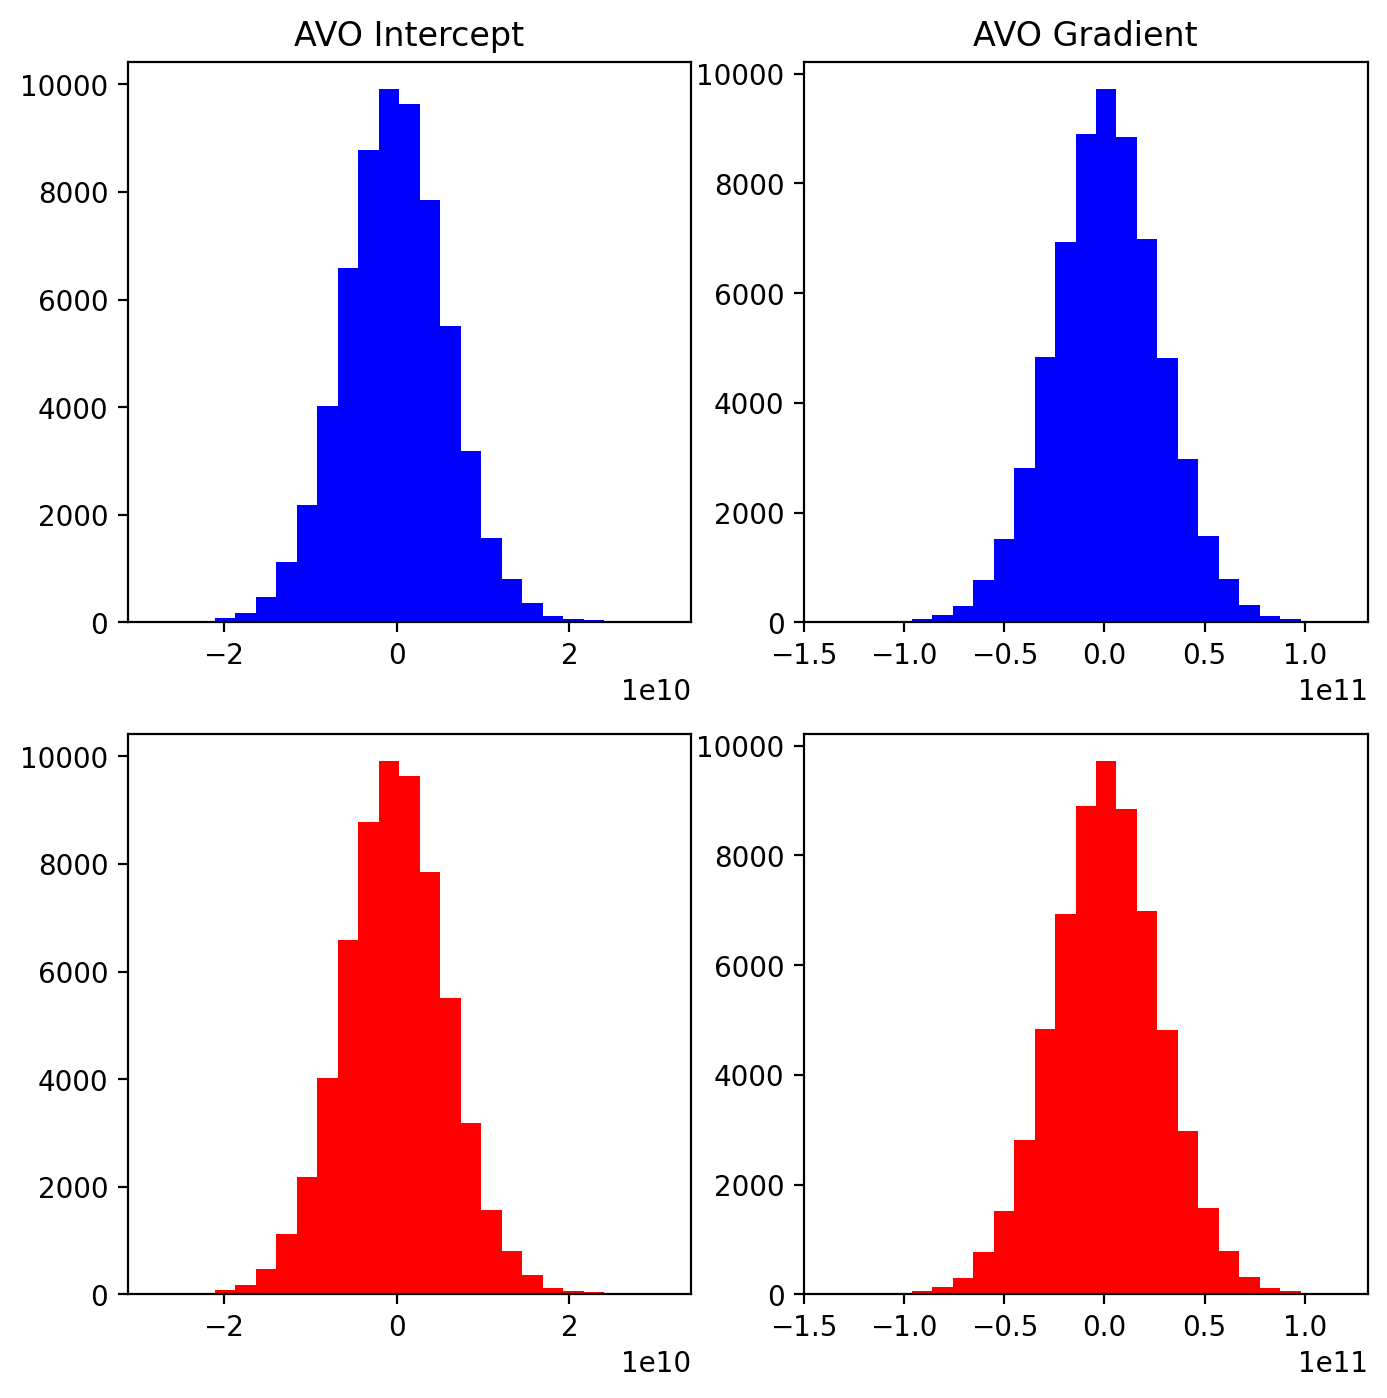

In [25]:
f, ax = plt.subplots(nrows=2,ncols=2, figsize=(8,8))
ax[0,0].hist(avo_I1.ravel(), bins=25, color='b')
ax[0,1].hist(avo_G1.ravel(), bins=25, color='b')
ax[1,0].hist(avo_I3.ravel(), bins=25, color='r')
ax[1,1].hist(avo_G3.ravel(), bins=25, color='r')
ax[0,0].set_title('AVO Intercept')
ax[0,1].set_title('AVO Gradient')

And if we look at the resulting maps we also see that they're the same (I also show the differences between the intercept and gradient maps calculated with the two methods):

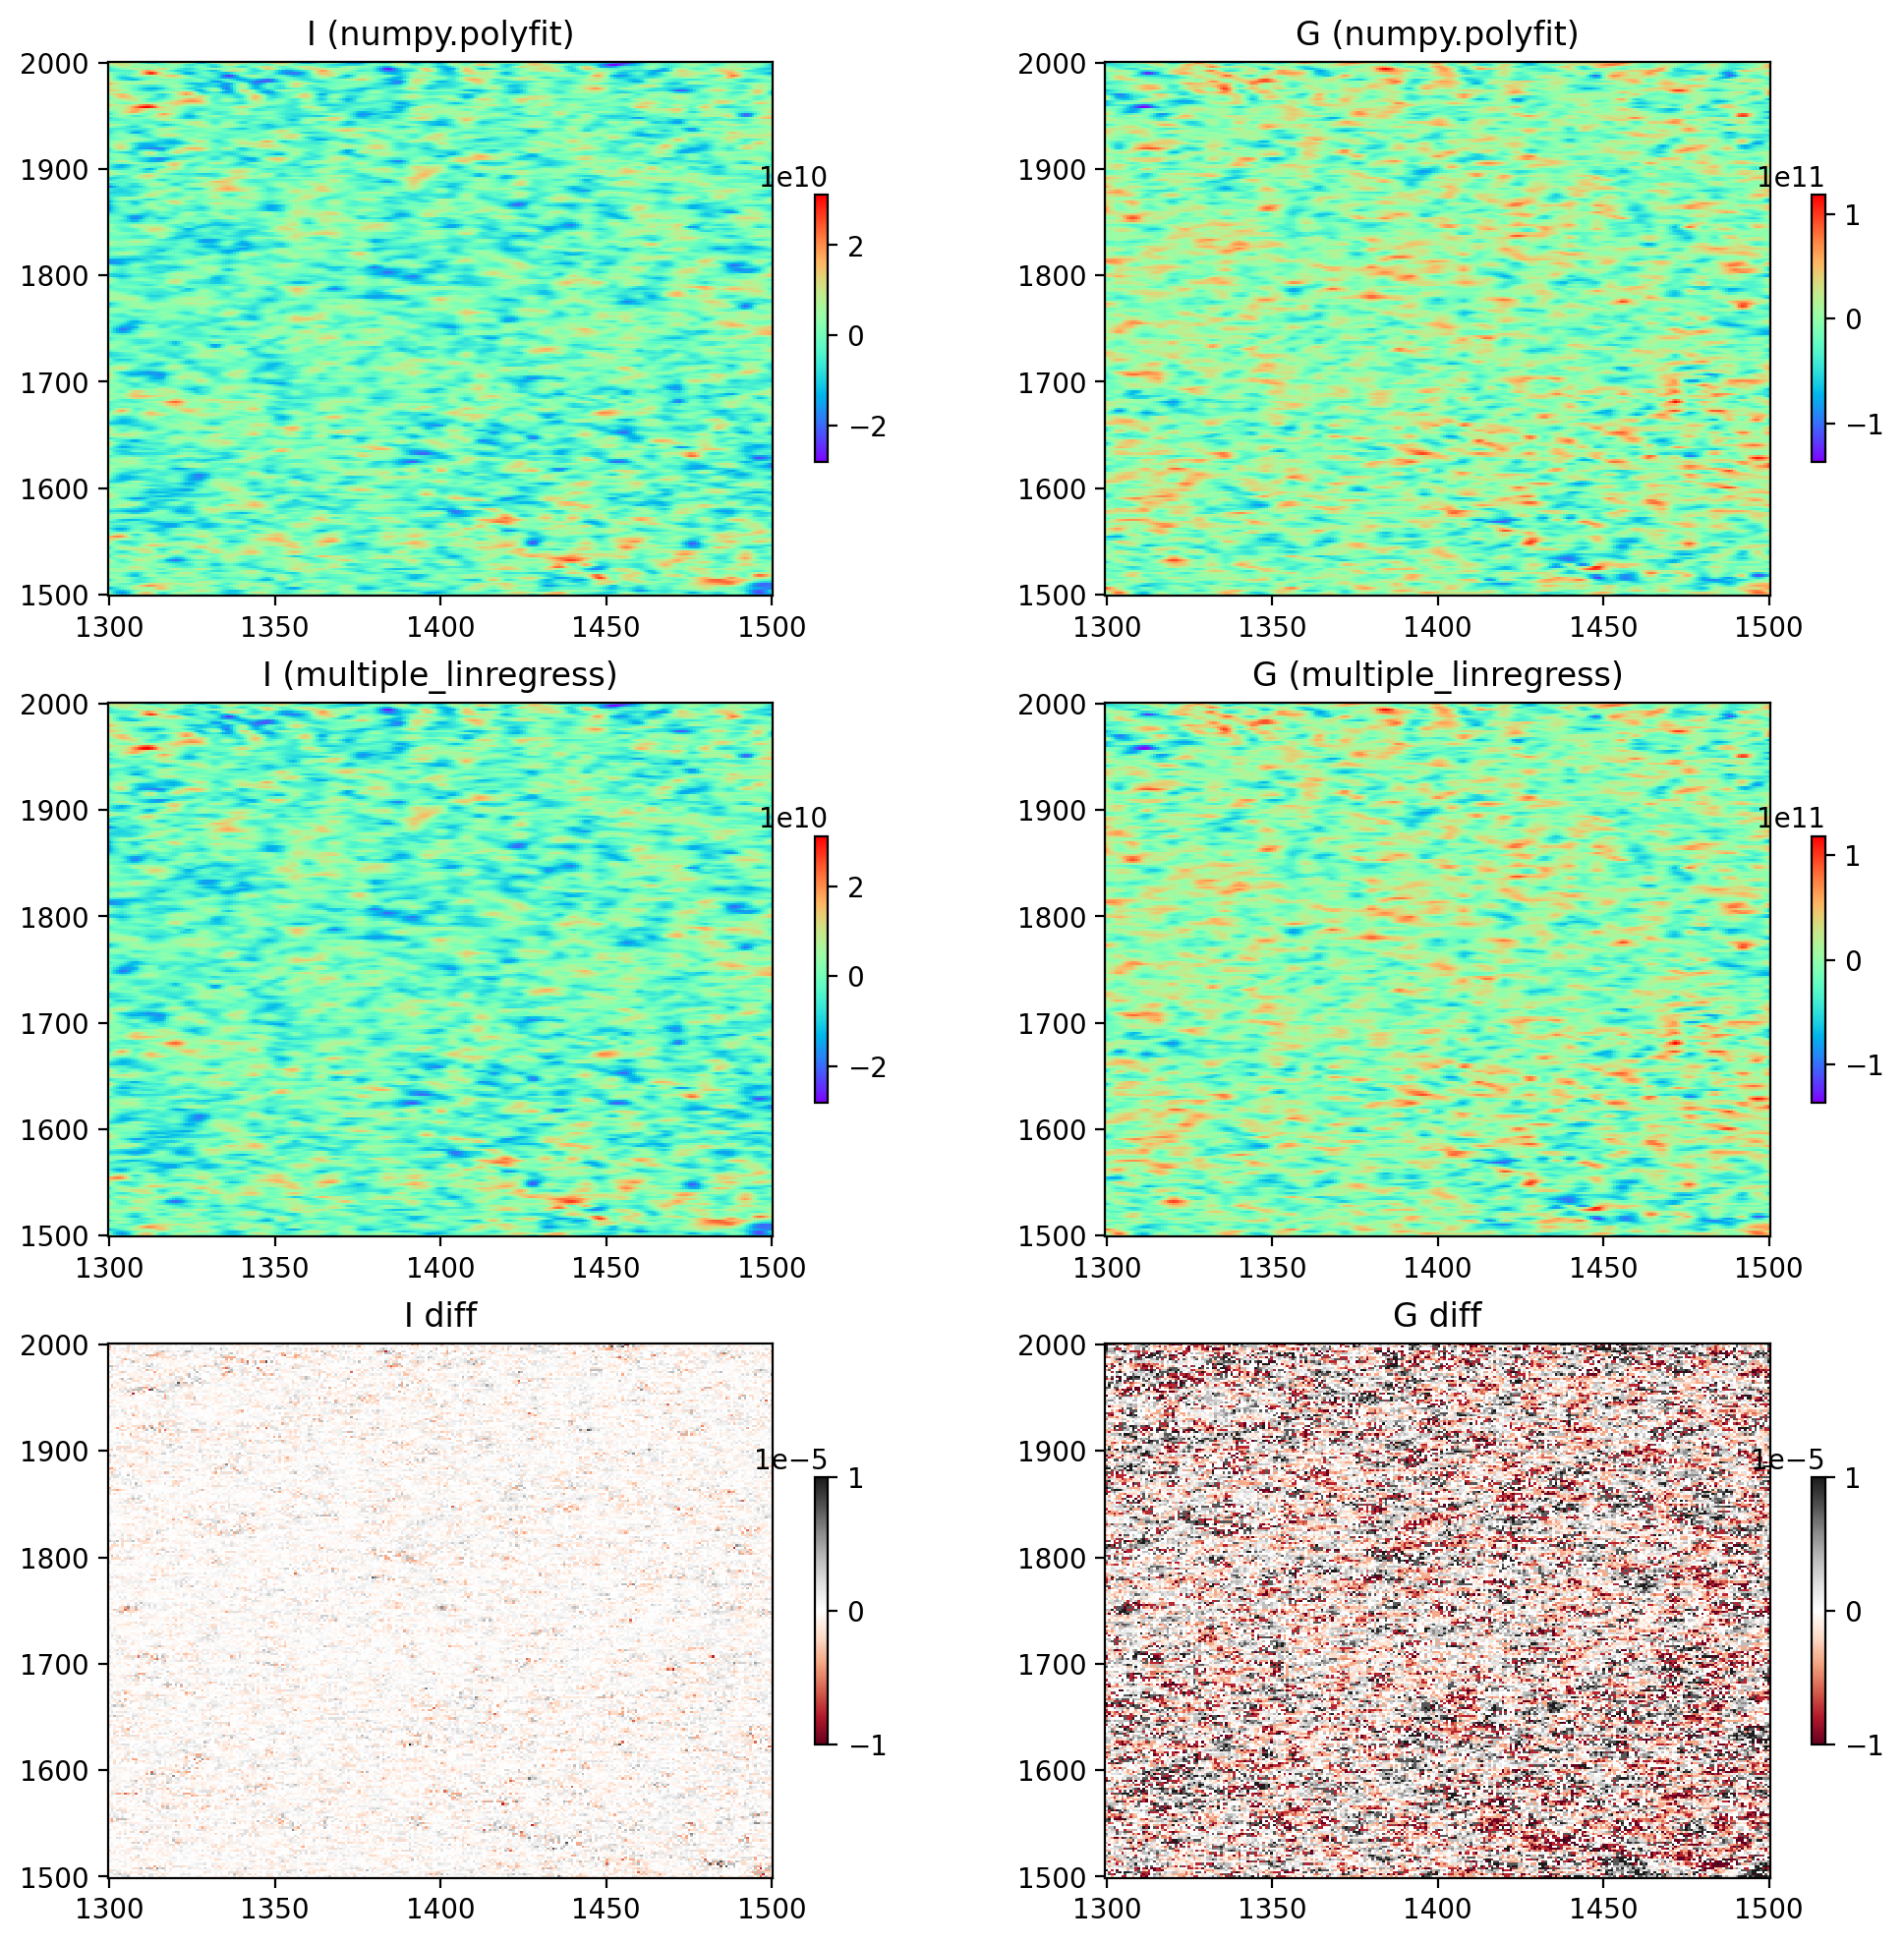

In [31]:
avo_I1=avo_I1.reshape(X.shape)
avo_G1=avo_G1.reshape(Y.shape)
avo_I3=avo_I3.reshape(X.shape)
avo_G3=avo_G3.reshape(Y.shape)

clip_min_I=np.min([avo_I1, avo_I3])
clip_max_I=np.max([avo_I1, avo_I3])
clip_min_G=np.min([avo_G1, avo_G3])
clip_max_G=np.max([avo_G1, avo_G3])
    
f, ax = plt.subplots(nrows=3,ncols=2,figsize=(12,12))
map0 = ax[0,0].pcolormesh(X, Y, avo_I1, cmap=colr, vmin=clip_min_I, vmax=clip_max_I)
map1 = ax[0,1].pcolormesh(X, Y, avo_G1, cmap=colr, vmin=clip_min_G, vmax=clip_max_G)
map2 = ax[1,0].pcolormesh(X, Y, avo_I3, cmap=colr, vmin=clip_min_I, vmax=clip_max_I)
map3 = ax[1,1].pcolormesh(X, Y, avo_G3, cmap=colr, vmin=clip_min_G, vmax=clip_max_G)
map4 = ax[2,0].pcolormesh(X, Y, avo_I1-avo_I3, cmap='RdGy', vmin=-.00001, vmax=.00001)
map5 = ax[2,1].pcolormesh(X, Y, avo_G1-avo_G3, cmap='RdGy', vmin=-.00001, vmax=.00001)

ax[0,0].set_title('I (numpy.polyfit)')
ax[0,1].set_title('G (numpy.polyfit)')
ax[1,0].set_title('I (multiple_linregress)')
ax[1,1].set_title('G (multiple_linregress)')
ax[2,0].set_title('I diff')
ax[2,1].set_title('G diff')

plt.colorbar(map0, ax=ax[0,0], shrink=0.5)
plt.colorbar(map1, ax=ax[0,1], shrink=0.5)
plt.colorbar(map2, ax=ax[1,0], shrink=0.5)
plt.colorbar(map3, ax=ax[1,1], shrink=0.5)
plt.colorbar(map4, ax=ax[2,0], shrink=0.5)
plt.colorbar(map5, ax=ax[2,1], shrink=0.5)

## display

Displaying the original AVO maps with the new ones I have calculated I see similar ranges of values but different pictures; the main problem is that I don't really know anything about the provided intercept and gradient maps, so I will need to do compare the results obtained in Python with the output of a commercial application (e.g., Petrel, Hampson-Russell, etc).

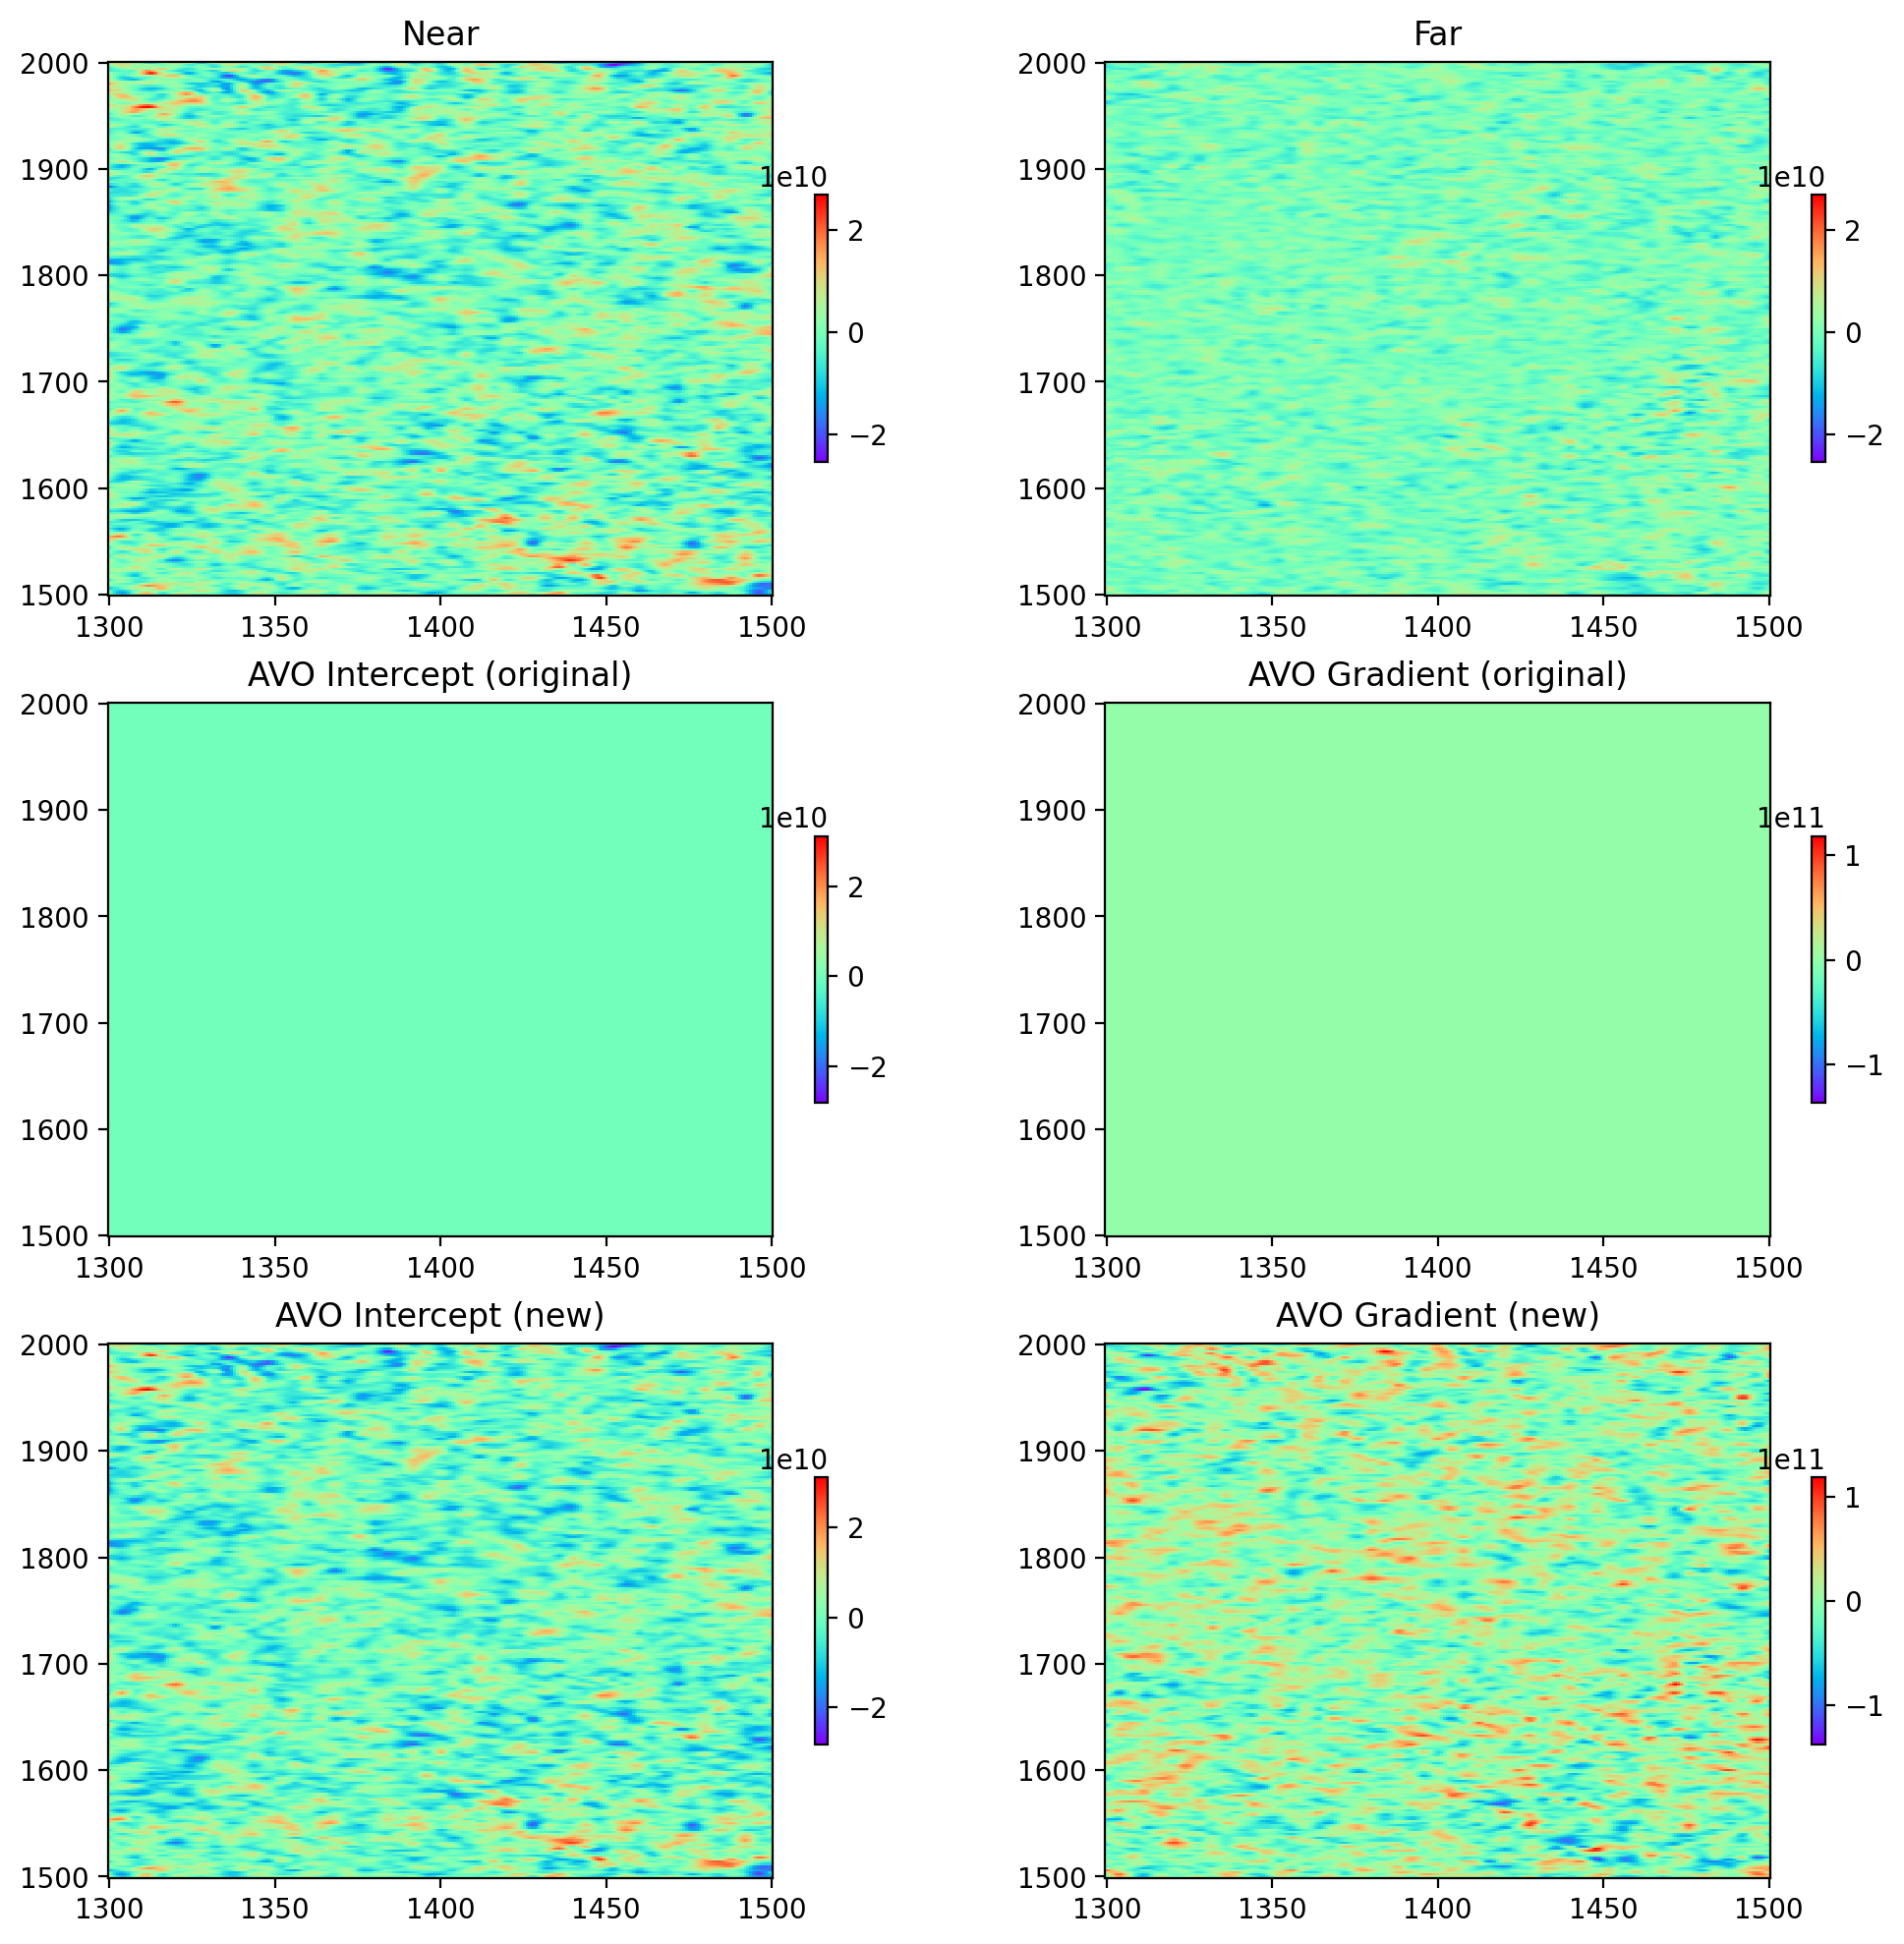

In [32]:
avo_I3=avo_I3.reshape(X.shape)
avo_G3=avo_G3.reshape(Y.shape)

clip_max=np.max(hrz_extr[:,3:4])
clip_min=np.min(hrz_extr[:,3:4])

f, ax = plt.subplots(nrows=3,ncols=2,figsize=(12,12))
map0 = ax[0,0].pcolormesh(X, Y, An,     cmap=colr, vmin=clip_min,   vmax=clip_max)
map1 = ax[0,1].pcolormesh(X, Y, Af,     cmap=colr, vmin=clip_min,   vmax=clip_max)
map2 = ax[1,0].pcolormesh(X, Y, I,      cmap=colr, vmin=clip_min_I, vmax=clip_max_I)
map3 = ax[1,1].pcolormesh(X, Y, G,      cmap=colr, vmin=clip_min_G, vmax=clip_max_G)
map4 = ax[2,0].pcolormesh(X, Y, avo_I3, cmap=colr, vmin=clip_min_I, vmax=clip_max_I)
map5 = ax[2,1].pcolormesh(X, Y, avo_G3, cmap=colr, vmin=clip_min_G, vmax=clip_max_G)
ax[0,0].set_title('Near')
ax[0,1].set_title('Far')
ax[1,0].set_title('AVO Intercept (original)')
ax[1,1].set_title('AVO Gradient (original)')
ax[2,0].set_title('AVO Intercept (new)')
ax[2,1].set_title('AVO Gradient (new)')
plt.colorbar(map0, ax=ax[0,0], shrink=0.5)
plt.colorbar(map1, ax=ax[0,1], shrink=0.5)
plt.colorbar(map2, ax=ax[1,0], shrink=0.5)
plt.colorbar(map3, ax=ax[1,1], shrink=0.5)
plt.colorbar(map4, ax=ax[2,0], shrink=0.5)
plt.colorbar(map5, ax=ax[2,1], shrink=0.5)

***

_Thanks to Evan Bianco for comments and suggestions._